图像输入 ➔ 目标检测模型yolov8 ➔ 生成边界框（头、鳍、甲壳） 边界框 ➔ SAM 模型 ➔ 分割掩码（精确的头、鳍和甲壳分割） 输出分割结果

In [7]:
import os
import json
import shutil
import random

def get_output_dirs(image_id, train_ids, train_labels_dir, test_labels_dir, train_images_dir, test_images_dir):
    """根据 image_id 判断属于训练集或测试集，并返回相应的 labels 和 images 目录"""
    if image_id in train_ids:
        return train_labels_dir, train_images_dir
    else:
        return test_labels_dir, test_images_dir

def convert_coco_to_yolo(annotations_file, images_dir, output_dir, split_ratio=0.8):
    with open(annotations_file) as f:
        data = json.load(f)

    # 创建训练和测试集的 labels 和 images 目录
    train_labels_dir = os.path.join(output_dir, 'labels', 'train')
    test_labels_dir = os.path.join(output_dir, 'labels', 'test')
    train_images_dir = os.path.join(output_dir, 'images', 'train')
    test_images_dir = os.path.join(output_dir, 'images', 'test')

    os.makedirs(train_labels_dir, exist_ok=True)
    os.makedirs(test_labels_dir, exist_ok=True)
    os.makedirs(train_images_dir, exist_ok=True)
    os.makedirs(test_images_dir, exist_ok=True)

    # 获取所有图片 id，并按照 split_ratio 随机分为训练和测试集
    image_ids = [img['id'] for img in data['images']]
    random.shuffle(image_ids)
    train_size = int(len(image_ids) * split_ratio)
    train_ids = set(image_ids[:train_size])

    for annotation in data['annotations']:
        image_id = annotation['image_id']
        image_info = next(img for img in data['images'] if img['id'] == image_id)
        width, height = image_info['width'], image_info['height']

        # YOLO 格式的边界框坐标转换
        x_min, y_min, box_width, box_height = annotation['bbox']
        x_center = (x_min + box_width / 2) / width
        y_center = (y_min + box_height / 2) / height
        w = box_width / width
        h = box_height / height
        category_id = annotation['category_id'] - 1  # YOLO 使用 0 开始的类别索引

        # 根据数据集类型选择 labels 和 images 目录
        labels_dir, images_output_dir = get_output_dirs(
            image_id, train_ids, train_labels_dir, test_labels_dir, train_images_dir, test_images_dir
        )

        # 保存标签文件
        img_name = image_info['file_name'].split('.')[0].split('/')[-1]
        label_path = os.path.join(labels_dir, f"{img_name}.txt")
        with open(label_path, 'a') as f:
            f.write(f"{category_id} {x_center} {y_center} {w} {h}\n")

        # 复制图片到相应的文件夹
        src_image_path = os.path.join(images_dir, image_info['file_name'])
        dest_image_path = os.path.join(images_output_dir, f"{img_name}.jpg")
        if not os.path.exists(dest_image_path):  # 避免重复复制
            shutil.copy2(src_image_path, dest_image_path)

# 执行转换并生成文件夹
convert_coco_to_yolo(
    annotations_file='D:/archive/turtles-data/data/annotations_train.json',
    images_dir='D:/archive/turtles-data/data',
    output_dir='D:/archive/turtles-data',
    split_ratio=0.8  # 80% 训练集, 20% 测试集
)


In [8]:
!pip install ultralytics




[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
from ultralytics import YOLO

# 加载预训练的 YOLOv8 模型
model = YOLO('yolov8s.pt')  # 加载小型 YOLOv8 模型，其他选择有 'yolov8m.pt'、'yolov8l.pt' 等

# 配置训练
model.train(
    data='D:/archive/turtles-data/data.yaml',  # 数据配置文件路径
    epochs=3,  # 训练轮数
    imgsz=256,  # 输入图片尺寸
    batch=32,  # 批量大小
    name='turtle_detection_yolov8',  # 训练结果保存文件夹名称
    project='D:/archive/turtles-data/runs'  # 保存结果的路径
)


New https://pypi.org/project/ultralytics/8.3.27 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.138  Python-3.9.12 torch-2.2.2+cu118 CPU (12th Gen Intel Core(TM) i7-12700H)
engine\trainer: task=detect, mode=train, model=yolov8s.pt, data=D:/archive/turtles-data/data.yaml, epochs=3, patience=50, batch=32, imgsz=256, save=True, save_period=-1, cache=False, device=None, workers=8, project=D:/archive/turtles-data/runs, name=turtle_detection_yolov8, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=F


image 1/1 D:\archive\turtles-data\data\images\t001\CAluWEgwPX.JPG: 192x256 1 shell, 3 fins, 1 head, 160.8ms
Speed: 2.7ms preprocess, 160.8ms inference, 1.0ms postprocess per image at shape (1, 3, 192, 256)


IOU for predicted shell in image images/t001/CAluWEgwPX.JPG: 0.9963
IOU for predicted head in image images/t001/CAluWEgwPX.JPG: 0.8289
IOU for predicted fin in image images/t001/CAluWEgwPX.JPG: 0.9876
IOU for predicted fin in image images/t001/CAluWEgwPX.JPG: 0.8788
IOU for predicted fin in image images/t001/CAluWEgwPX.JPG: 0.9864


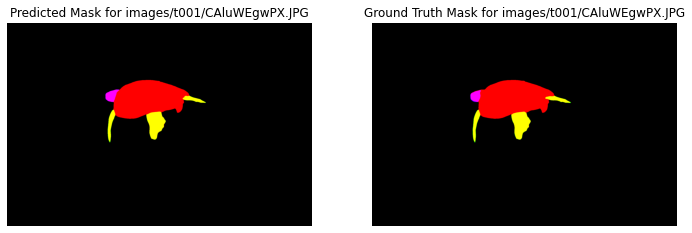


image 1/1 D:\archive\turtles-data\data\images\t001\LZystXlIqe.JPG: 192x256 1 shell, 3 fins, 1 head, 222.1ms
Speed: 1.9ms preprocess, 222.1ms inference, 3.6ms postprocess per image at shape (1, 3, 192, 256)


IOU for predicted shell in image images/t001/LZystXlIqe.JPG: 0.9957
IOU for predicted fin in image images/t001/LZystXlIqe.JPG: 0.9901
IOU for predicted fin in image images/t001/LZystXlIqe.JPG: 0.9890
IOU for predicted head in image images/t001/LZystXlIqe.JPG: 0.8716
IOU for predicted fin in image images/t001/LZystXlIqe.JPG: 0.9884


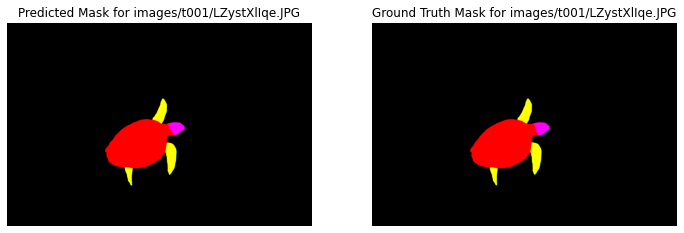


image 1/1 D:\archive\turtles-data\data\images\t001\VMyJozldvy.jpg: 256x160 1 shell, 5 fins, 1 head, 174.2ms
Speed: 2.4ms preprocess, 174.2ms inference, 2.1ms postprocess per image at shape (1, 3, 256, 160)


IOU for predicted shell in image images/t001/VMyJozldvy.jpg: 0.9963
IOU for predicted fin in image images/t001/VMyJozldvy.jpg: 0.9907
IOU for predicted fin in image images/t001/VMyJozldvy.jpg: 0.9882
IOU for predicted head in image images/t001/VMyJozldvy.jpg: 0.9154
IOU for predicted fin in image images/t001/VMyJozldvy.jpg: 0.9925
IOU for predicted fin in image images/t001/VMyJozldvy.jpg: 0.9803
No valid mask found for predicted fin in image images/t001/VMyJozldvy.jpg. Skipping.


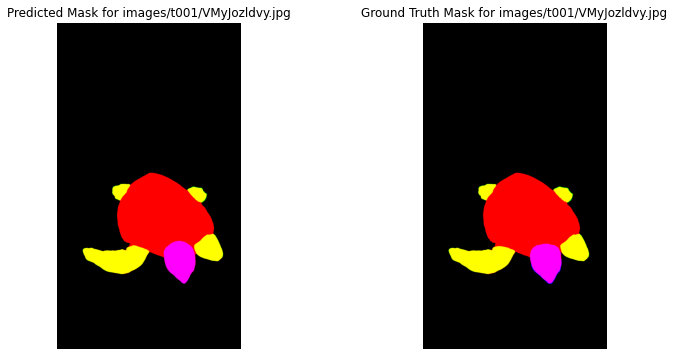


image 1/1 D:\archive\turtles-data\data\images\t001\ZKnMahXQgJ.JPG: 160x256 2 shells, 3 fins, 1 head, 164.0ms
Speed: 1.9ms preprocess, 164.0ms inference, 2.0ms postprocess per image at shape (1, 3, 160, 256)


IOU for predicted shell in image images/t001/ZKnMahXQgJ.JPG: 0.9950
IOU for predicted fin in image images/t001/ZKnMahXQgJ.JPG: 0.9685
IOU for predicted fin in image images/t001/ZKnMahXQgJ.JPG: 0.9810
IOU for predicted head in image images/t001/ZKnMahXQgJ.JPG: 0.6212
IOU for predicted shell in image images/t001/ZKnMahXQgJ.JPG: 0.9945
IOU for predicted fin in image images/t001/ZKnMahXQgJ.JPG: 0.9882


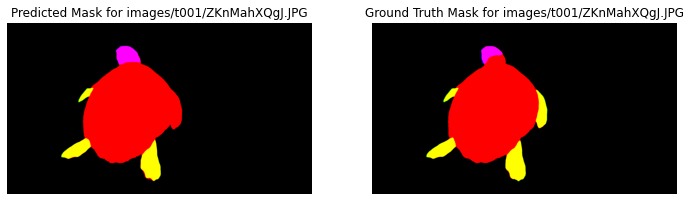


image 1/1 D:\archive\turtles-data\data\images\t002\pIHJimnzHb.JPG: 160x256 1 shell, 4 fins, 1 head, 201.0ms
Speed: 2.0ms preprocess, 201.0ms inference, 2.0ms postprocess per image at shape (1, 3, 160, 256)


IOU for predicted shell in image images/t002/pIHJimnzHb.JPG: 0.9970
IOU for predicted fin in image images/t002/pIHJimnzHb.JPG: 0.9939
IOU for predicted fin in image images/t002/pIHJimnzHb.JPG: 0.9952
IOU for predicted fin in image images/t002/pIHJimnzHb.JPG: 0.9909
IOU for predicted head in image images/t002/pIHJimnzHb.JPG: 0.7891
IOU for predicted fin in image images/t002/pIHJimnzHb.JPG: 0.9758


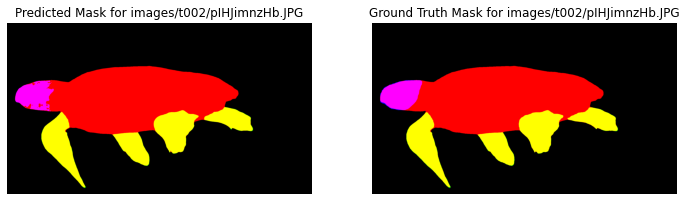


image 1/1 D:\archive\turtles-data\data\images\t002\waDhOeKzuw.jpg: 160x256 1 shell, 1 fin, 1 head, 202.4ms
Speed: 3.1ms preprocess, 202.4ms inference, 2.0ms postprocess per image at shape (1, 3, 160, 256)


IOU for predicted shell in image images/t002/waDhOeKzuw.jpg: 0.9982
IOU for predicted fin in image images/t002/waDhOeKzuw.jpg: 0.9884
IOU for predicted head in image images/t002/waDhOeKzuw.jpg: 0.9363


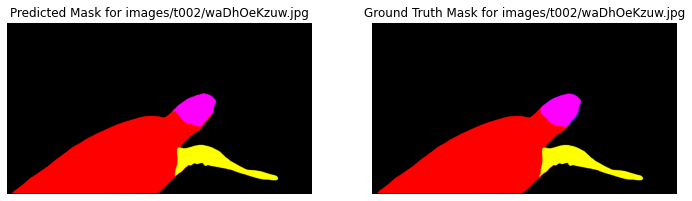

Average IOU for shell: 0.9961
Average IOU for fin: 0.9808
Average IOU for head: 0.8271


In [18]:
import json
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamPredictor
from sklearn.metrics import jaccard_score
from pycocotools import mask as coco_mask
from ultralytics import YOLO
from collections import defaultdict

# 配置路径
annotations_path = 'D:/archive/turtles-data/data/annotations_test.json'
image_folder = 'D:/archive/turtles-data/data/'
sam_checkpoint = "D:/sam_vit_h_4b8939.pth"
yolo_checkpoint = "D:/archive/turtles-data/runs/turtle_detection_yolov86/weights/best.pt"

# 加载 JSON 文件，获取所有图片和注释信息
with open(annotations_path, 'r') as f:
    data = json.load(f)

# 加载 YOLOv8 和 SAM 模型
yolo_model = YOLO(yolo_checkpoint)
model_type = "vit_h"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
predictor = SamPredictor(sam)

# 初始化每个类别的 IoU 累计和计数
iou_scores = defaultdict(float)  # 每个类别的 IoU 总和
iou_counts = defaultdict(int)     # 每个类别的掩码数量

# 类别名称列表，与 data.yaml 中 names 列表一致
category_names = ['shell', 'fin', 'head']
category_colors = {
    0: [1, 0, 0],     # 红色
    1: [0, 1, 0],     # 绿色
    2: [0, 0, 1],     # 蓝色
}

# 遍历所有图片
for idx,image_info in enumerate(data['images']):
    image_id = image_info['id']
    annotations_info = [ann for ann in data['annotations'] if ann['image_id'] == image_id]
    
    # 加载图片
    image_path = f"{image_folder}/{image_info['file_name']}"
    image = Image.open(image_path)
    image_np = np.array(image)

    # 使用 YOLOv8 模型获取预测边界框
    results = yolo_model.predict(source=image_path, imgsz=256)
    bboxes = results[0].boxes.xyxy.cpu().numpy()  # YOLOv8 预测框
    class_ids = results[0].boxes.cls.cpu().numpy()  # YOLOv8 预测类别

    # 设置 SAM 模型图像
    predictor.set_image(image_np)

    # 创建黑色背景作为预测分割结果
    pred_colored_mask = np.zeros((image_np.shape[0], image_np.shape[1], 3))
    gt_colored_mask = np.zeros((image_np.shape[0], image_np.shape[1], 3))  # gt分割结果

    # 遍历每个预测框，按类别计算 IoU 并选择最大 IoU 的掩码
    for i, bbox in enumerate(bboxes):
        x_min, y_min, x_max, y_max = bbox
        box_prompt = np.array([x_min, y_min, x_max, y_max]).reshape(1, -1)
        
        # 使用 SAM 模型预测分割掩码
        masks, scores, _ = predictor.predict(box=box_prompt)
        
        # 获取类别 ID 和颜色
        class_id = int(class_ids[i])
        category_id = class_id + 1  # 转换为注释中的 category_id
        color = category_colors.get(class_id, [1, 1, 1])  # 获取类别颜色
        class_name = category_names[class_id]  # 获取类别名称

        # 获取该类别的所有真实掩码
        ground_truth_masks = []
        for ann in annotations_info:
            if ann['category_id'] == category_id:
                rle_encoded = ann['segmentation']
                gt_mask = coco_mask.decode(coco_mask.frPyObjects(rle_encoded, image_np.shape[0], image_np.shape[1])).astype(bool)
                ground_truth_masks.append(gt_mask)

        # 计算每个预测掩码与所有真实掩码的 IoU，选择最大值作为该边界框的最终掩码
        best_mask = None
        best_iou = 0
        for mask in masks:
            max_iou = 0
            for gt_mask in ground_truth_masks:
                pred_mask_flat = mask.flatten()
                gt_mask_flat = gt_mask.flatten()
                iou = jaccard_score(gt_mask_flat, pred_mask_flat, average='binary')
                if iou > max_iou:
                    max_iou = iou
            # 记录 IoU 最大的 mask 及其 IoU
            if max_iou > best_iou:
                best_iou = max_iou
                best_mask = mask
        
        # 仅累加 IoU 最大的 mask
        if best_mask is not None:
            iou_scores[class_name] += best_iou
            iou_counts[class_name] += 1
            print(f"IOU for predicted {class_name} in image {image_info['file_name']}: {best_iou:.4f}")

            # 将最佳掩码叠加到预测结果背景
            expanded_best_mask = np.zeros((*best_mask.shape, 3))
            for j in range(3):
                expanded_best_mask[:, :, j] = best_mask * color[j]
            pred_colored_mask = np.where(expanded_best_mask > 0, expanded_best_mask, pred_colored_mask)

            # 显示 Ground Truth 掩码
            for gt_mask in ground_truth_masks:
                expanded_gt_mask = np.zeros((*gt_mask.shape, 3))
                for j in range(3):
                    expanded_gt_mask[:, :, j] = gt_mask * color[j]
                gt_colored_mask = np.where(expanded_gt_mask > 0, expanded_gt_mask, gt_colored_mask)
        else:
            print(f"No valid mask found for predicted {class_name} in image {image_info['file_name']}. Skipping.")

    # 可视化当前图片的预测分割和原始分割
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(pred_colored_mask)
    axes[0].set_title(f"Predicted Mask for {image_info['file_name']}")
    axes[0].axis("off")
    axes[1].imshow(gt_colored_mask)
    axes[1].set_title(f"Ground Truth Mask for {image_info['file_name']}")
    axes[1].axis("off")
    plt.show()
    
    if idx == 5:
        break

# 计算并打印每个类别的平均 IoU
for class_name in category_names:
    if iou_counts[class_name] > 0:
        avg_iou = iou_scores[class_name] / iou_counts[class_name]
        print(f"Average IOU for {class_name}: {avg_iou:.4f}")
    else:
        print(f"No predictions for {class_name}")
